# Systrace Parser

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

2019-11-23 06:04:27,544 INFO    : root         : Using LISA logging configuration:
2019-11-23 06:04:27,545 INFO    : root         :   /home/ubuntu/Android/lisa_old/logging.conf


In [2]:
%pylab inline

import os
from time import sleep

# Support to access the remote target
import devlib
from env import TestEnv

# Import support for Android devices
from android import Screen, Workload

from devlib.utils.android import adb_command

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy
import glob

import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame

import ipywidgets as widgets
from IPython.display import display

from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import Javascript, display

from android import System

import subprocess

from systrace_parser import systrace_parser

2019-11-23 06:04:27,804 INFO    : root         : Generating grammar tables from /usr/lib/python2.7/lib2to3/Grammar.txt
2019-11-23 06:04:27,818 INFO    : root         : Generating grammar tables from /usr/lib/python2.7/lib2to3/PatternGrammar.txt


Populating the interactive namespace from numpy and matplotlib


## Test environment setup

**devlib** requires the ANDROID_HOME environment variable configured to point to your local installation of the Android SDK. If you have not this variable configured in the shell used to start the notebook server, you need to run a cell to define where your Android SDK is installed or specify the ANDROID_HOME in your target configuration.

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in **my_target_conf**. Run **adb devices** on your host to get the ID.

In [3]:
import os
os.environ['ANDROID_HOME'] = '/home/ubuntu/Android/AndroidSDK/'

In [4]:
conf = {
    
    # Target platform and board
    "platform"    : 'android',
    "board"       : 'pixel',

    # Device ID
    #"device"      : "HT6670300102",
    
    # Android home
    "ANDROID_HOME" : "/home/ubuntu/Android/AndroidSDK",
    
    # Lisa home
    "LISA_HOME" : "/home/ubuntu/Android/lisa_old",

    # Systrace home
    "SYSTRACE_HOME" : "/ipynb/performance/testingdata",
    
    "MAX_CORE_NUM" : 8
}

## Filters

In [6]:
trace_mark_filters = {
    'launching' : {
        'SMARK' : {'context' : 'launching:', 'type' : 'S'}, 
        'EMARK' : {'context' : 'launching:', 'type' : 'F'},
    },
    'ActivityThreadMain' : {
        'SMARK' : {'context' : 'ActivityThreadMain', 'type' : 'B'}, 
        'EMARK' : {'context' : 'ActivityThreadMain', 'type' : 'E'},
    },
    'bindApplication' : {
        'SMARK' : {'context' : 'bindApplication', 'type' : 'B'}, 
        'EMARK' : {'context' : 'bindApplication', 'type' : 'E'},
    },
    'activityStart' : {
        'SMARK' : {'context' : 'activityStart', 'type' : 'B'}, 
        'EMARK' : {'context' : 'activityStart', 'type' : 'E'},
    },
    'activityResume' : {
        'SMARK' : {'context' : 'activityResume', 'type' : 'B'}, 
        'EMARK' : {'context' : 'activityResume', 'type' : 'E'},
    },
    'Choreographer' : {
        'SMARK' : {'context' : 'Choreographer#doFrame', 'type' : 'B'}, 
        'EMARK' : {'context' : 'Choreographer#doFrame', 'type' : 'E'},
        'SEPERATE' : [0, 1],
    },
    'setSurface' : {
        'SMARK' : {'context' : 'setSurface', 'type' : 'B'}, 
        'EMARK' : {'context' : 'setSurface', 'type' : 'E'},
    },
}

In [7]:
def MismatchedStringWithoutNumber(comp1, comp2):
    comp1 = unicode(comp1)
    comp2 = unicode(comp2)
    count = 0
    for index in range(min(len(comp1), len(comp2))):
        if comp1[index] != comp2[index] and not comp1[index].isnumeric() and not comp1[index].isnumeric():
            count += 1
            
    return count
#print(MismatchedStringWithoutNumber('A207FSH9_POS_190822_190822_104817_calllog?', 'A207FSH9_POS_190822_180922_104475_calllog1'))

## Select systraces

In [8]:

count = 0
dirname = ''
dirnames = ''
chboxes = list()
chboxes_descriptions = list()

for (path, dir, files) in os.walk(conf['LISA_HOME'] + conf['SYSTRACE_HOME'] + '/'):
    if len(dir) > 0:
        dirnames = dir
    file_groups = list()
    for filename in files:
        if filename.split('.')[-1] == 'html':
            filename = filename[:-5]
            #print(filename)
            new_one = True
            for file_group in file_groups:
                #length_of_file = len(filename)
                #if length_of_file == len(file_group) and filename[:length_of_file/2] == file_group[:length_of_file/2]:
                if not MismatchedStringWithoutNumber(filename, file_group):
                    #print('before  {}'.format(file_groups))
                    #if not file_group.contains('[?]'):
                    #    file_groups.remove(file_group)
                        #file_groups.append('{}?{}'.format(file_group[:-6],file_group[-5:]))
                    #    file_groups.append('{}[?]'.format(file_group[:-3]))
                        #print('after  {}'.format(file_groups))
                    new_one = False
                    break
            if new_one:
                file_groups.append(filename)

    for file_group in file_groups:
        chboxes_descriptions.append('{}{}'.format(dirname, file_group))
    if len(dirnames) > count:
        dirname = dirnames[count] + '/'
    else:
        dirname = ''
    count += 1
    
chboxes_descriptions.sort()
#display(chboxes_descriptions)
for chboxes_description in chboxes_descriptions:
        chboxes.append(widgets.Checkbox(
                value=False,
                description=chboxes_description.decode("utf-8"),
                disabled=False,
                layout=widgets.Layout(width="200%"),
                style={'description_width': 'initial'}
        ))

toggle = widgets.ToggleButton(
    description='START'
)

#chboxes[4].value = True
#chboxes[16].value = True

display(widgets.VBox(chboxes))

VkJveChjaGlsZHJlbj0oQ2hlY2tib3godmFsdWU9RmFsc2UsIGRlc2NyaXB0aW9uPXUnQTAxNUYvQTAxNUZTSzVfUU9TXzE5MTEyMV8xOTExMjFfMTE1MzU4X2hlbGxvd29ybGQnLCBsYXlvdXTigKY=


## Run cells

Please select over two of systrace files and press the run button to execute below cells.
You could see the some graphs of group1 or gruop2 to compare.

In [40]:
def run_all(button):
    #get_ipython().run_cell()
    display(Javascript('IPython.notebook.execute_cells_below()'))

button = widgets.Button(description="Run all below")
button.on_click(run_all)
display(button)

<IPython.core.display.Javascript object>

Button(description=u'Run all below', style=ButtonStyle())

## Get file list

In [41]:
filelist = list()
title = list()

for chbox in chboxes:
    if chbox.value:
        #print(chbox.description)
        file_path = chbox.description.split('/')
        new_file_path = ''
        if len(file_path) > 1:
            for idx in range(len(file_path) - 1):
                new_file_path += file_path[idx] + '/'
        #length_of_file = len(file_path[-1])
        #new_file_path += file_path[-1][:-3] + '*.html'
        new_file_path += '*.html'
        #print(new_file_path)
        
        gathering_filelist = list()
        for dir_file in glob.glob(conf['LISA_HOME'] + conf['SYSTRACE_HOME'] + '/' + new_file_path):
            if not MismatchedStringWithoutNumber(file_path[-1], dir_file.split('/')[-1]):
                #print(dir_file)
                gathering_filelist.append(dir_file)
        filelist.append(gathering_filelist)
        #filelist[-1].sort()
        title += [file_path[-2] + "_" + file_path[-1]]

if len(filelist) == 0:
    raise  ValueError('Please select some groups of systrace in the over cell.')

Please select two groups of systrace to analysis.

## Read Files

In [42]:
group1 = systrace_parser(trace_mark_filters, filelist[0], title[0])
group2 = systrace_parser(trace_mark_filters, filelist[1], title[1])

In [13]:
group1.run()
group2.run()

Parsing TEST1_POS_191010_191010_192902_contact.html - 178878 lines are Ok
Parsing TEST2TTTT_POS_191010_191010_231835_contact.html - 204101 lines are Ok


## Analysis

### The timing of marking data

The operation times of each trace_mark_filters tags of systrac.

In [14]:
list_of_df = group1.get_marking_time()
print(group1.title)
for df in list_of_df:
    display(df * 1000)

TEST_TEST1_POS_191010_191010_192902_contact


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
13344.0,NaN,NaN,NaN,693.366,NaN,11.550,NaN,NaN
13408.0,NaN,NaN,NaN,153.016,NaN,17.790,NaN,NaN
13314.0,19.678,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4136.0,NaN,3.388,3.762,NaN,NaN,NaN,NaN,NaN
4137.0,NaN,2.727,1.122,NaN,NaN,NaN,NaN,NaN
6314.0,NaN,129.184,64.350,NaN,348.342,NaN,35.388,NaN
4715.0,0.541,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4301.0,0.010,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13424.0,NaN,NaN,NaN,336509.506,NaN,13.965,NaN,NaN


In [15]:
list_of_df = group2.get_marking_time()
print(group2.title)
for df in list_of_df:
    display(df * 1000)

TEST_TEST2TTTT_POS_191010_191010_231835_contact


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
13605.0,NaN,NaN,NaN,399.454,NaN,15.011,NaN,NaN
13478.0,NaN,NaN,NaN,78.043,NaN,55.525,NaN,NaN
4134.0,NaN,1.681,0.068,NaN,NaN,NaN,NaN,NaN
4135.0,NaN,3.835,1.117,NaN,NaN,NaN,NaN,NaN
13559.0,NaN,NaN,NaN,704.332,NaN,10.575,NaN,NaN
6317.0,NaN,129.567,64.331,NaN,341.462,NaN,32.807,NaN
4719.0,0.483,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13583.0,NaN,NaN,NaN,328273.767,NaN,17.336,NaN,NaN
4305.0,0.011,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Launching Time(AVERAGE)

This section is showing the app launching time.

In [46]:
list_of_df = group1.get_marking_time()
count1 = 0

for df in list_of_df:
    get_launching = df[df['launching'] > 0]

    if len(get_launching.index) :
        count1 += 1
        try :
            sum_df1 = pd.concat([sum_df1, get_launching])
        except :
            sum_df1 = get_launching

try :
    sum_df1 = DataFrame(sum_df1.sum(axis=0)).swapaxes("index", "columns") 
    sum_df1.index = [group1.title]
    sum_df1 = sum_df1.replace(0, NaN).dropna(axis=1)
except:
    print("No launching time")

list_of_df = group2.get_marking_time()
count2 = 0

for df in list_of_df:
    get_launching = df[df['launching'] > 0]
    
    if len(get_launching.index) :
        count2 += 1
        try :
            sum_df2 = pd.concat([sum_df2, get_launching])
        except :
            sum_df2 = get_launching

try :
    sum_df2 = DataFrame(sum_df2.sum()).swapaxes("index", "columns") 
    sum_df2.index = [group2.title]
    sum_df2 = sum_df2.replace(0, NaN).dropna(axis=1)

    pd.concat([sum_df1 * 1000 / count1, sum_df2 * 1000 / count2])
except:
    print("No launching time")

/home/ubuntu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,launching
G975U_GLPreloading_G975U_P_TEST,487.651
G975U_GLPreloading_G975U_Q_TEST,511.748


### Process Time(AVERAGE)

Process time is from start to end timing within systrace tag of binadApplication / activityStart / ActivityThreadMain / ActivityResume.
 - time : total sum of time of running / runnable / sleeping / uninterruptible sleep.
 - running / runnable / sleeping / uninterruptible sleep : Process stat of cores.
 - setSurface : Just test and check the length of setSurface's tags.
 - launching : Sum of each tags, bindApplication, activityStart, ActivityThreadMain, activityResume, and Choreographer.

In [17]:
df1 = group1.get(systrace_parser.process_state()) * 1000
df1 = df1.fillna(0)
df1 = df1.round(3)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(systrace_parser.process_state()) * 1000
df2 = df2.fillna(0)
df2 = df2.round(3)
df2.columns.name = group2.title
#display(df2)

df_gap = df1 - df2
df_gap.columns.name = 'DIFF'
#display(df_gap)

display(pd.concat([df1, df2, df_gap], keys=[group1.title, group2.title, 'DIFF'], sort=False))
display(pd.concat([df1[:1], df2[:1], df_gap[:1]], keys=[group1.title, group2.title, 'DIFF'], sort=False))

setSurface  \
TEST_TEST1_POS_191010_191010_192902_contact     time                                0   
                                                RUNNING                             0   
                                                RUNNABLE                            0   
                                                SLEEPING                            0   
                                                UNINTERUPTIBLE_SLEEP                0   
                                                UNINTERUPTIBLE_SLEEP(I/O)           0   
TEST_TEST2TTTT_POS_191010_191010_231835_contact time                                0   
                                                RUNNING                             0   
                                                RUNNABLE                            0   
                                                SLEEPING                            0   
                                                UNINTERUPTIBLE_SLEEP                0   
                                                UNINTERUPTIBLE_SLEEP(I/O)           0   
DIFF                                            time                                0   
                                                RUNNING                             0   
                                                RUNNABLE                            0   
                                                SLEEPING                            0   
                                                UNINTERUPTIBLE_SLEEP                0   
                                                UNINTERUPTIBLE_SLEEP(I/O)           0   

                                                                           Choreographer #0  \
TEST_TEST1_POS_191010_191010_192902_contact     time                                129.184   
                                                RUNNING                             104.797   
                                                RUNNABLE                              0.690   
                                                SLEEPING                             21.395   
                                                UNINTERUPTIBLE_SLEEP                  0.124   
                                                UNINTERUPTIBLE_SLEEP(I/O)             2.178   
TEST_TEST2TTTT_POS_191010_191010_231835_contact time                                129.567   
                                                RUNNING                             103.258   
                                                RUNNABLE                              0.779   
                                                SLEEPING                             22.850   
                                                UNINTERUPTIBLE_SLEEP                  0.102   
                                                UNINTERUPTIBLE_SLEEP(I/O)             2.578   
DIFF                                            time                                 -0.383   
                                                RUNNING                               1.539   
                                                RUNNABLE                             -0.089   
                                                SLEEPING                             -1.455   
                                                UNINTERUPTIBLE_SLEEP                  0.022   
                                                UNINTERUPTIBLE_SLEEP(I/O)            -0.400   

                                                                           Choreographer #1  \
TEST_TEST1_POS_191010_191010_192902_contact     time                                 64.350   
                                                RUNNING                              20.804   
                                                RUNNABLE                              0.123   
                                                SLEEPING                             42.932   
                                                UNINTERUPTIBLE_SLEEP                  0.000   
       

,,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
TEST_TEST1_POS_191010_191010_192902_contact,time,0,129.184,64.350,0,348.342,0,35.388,0
TEST_TEST2TTTT_POS_191010_191010_231835_contact,time,0,129.567,64.331,0,341.462,0,32.807,0
DIFF,time,0,-0.383,0.019,0,6.880,0,2.581,0


### Processing time of setSurface

In [18]:
def ProcessingTime(group, index):
    result = dict()
    list_of_df = group.get_marking_time()
    sum = 0
    count = 0
    for df in list_of_df:
        df = df['setSurface'].fillna(0)
        max_value = df.max() * 1000
        sum += max_value
        count += 1
        result[count] = [max_value]
    #print("SUM : {}, AVG : {}".format(sum, sum/count))
    result['avg'] = [sum/count]
    
    df = DataFrame.from_dict(result)
    df.index = [group.title]
    return df

In [19]:
df1 = ProcessingTime(group1, 'setSurface')
df2 = ProcessingTime(group2, 'setSurface')
display(pd.concat([df1, df2]))

,1,avg
TEST_TEST1_POS_191010_191010_192902_contact,19.678,19.678
TEST_TEST2TTTT_POS_191010_191010_231835_contact,17.710,17.710


### Uninterruptible Sleep

The count of uninterruptible sleep within each tags.

In [50]:
index1 = group1.unint_sleep()
index2 = group2.unint_sleep()
union_index = index1
for index in index2:
    if not index in union_index:
        union_index += [index]

union_index.sort()
        
df1 = group1.get(union_index, func='avg').sort_index()
df1 = df1.dropna(axis=1)

df2 = group2.get(union_index, func='avg').sort_index()
df2 = df2.dropna(axis=1)

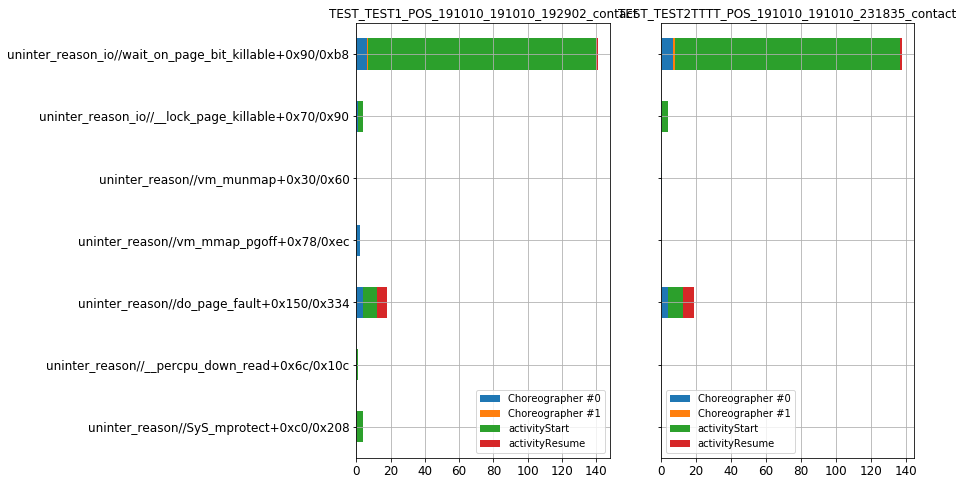

In [21]:
fig,axes = plt.subplots(nrows=1, ncols=2, sharey=True)

df1.plot(kind='barh', ax=axes[0], figsize=(10,8), grid=True, fontsize=12, stacked=True, title=group1.title)
df2.plot(kind='barh', ax=axes[1], figsize=(10,8), grid=True, fontsize=12, stacked=True, title=group2.title)

The number of count in each reason of uninterruptible sleep.

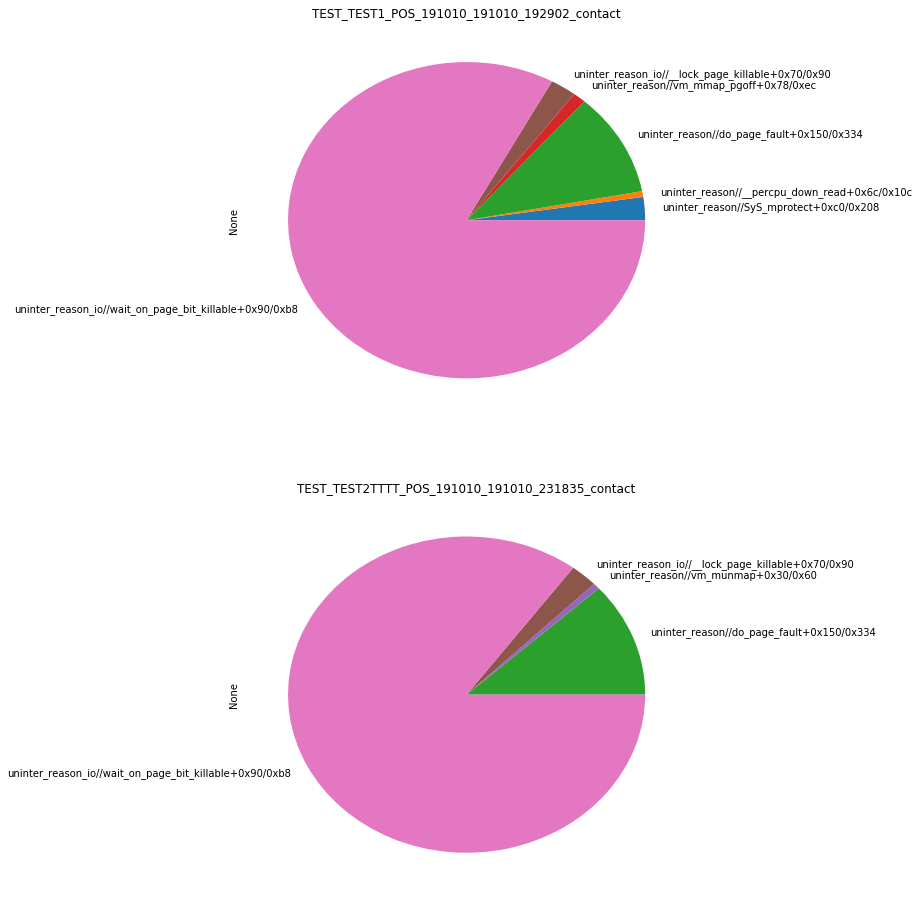

In [22]:
fig,axes = plt.subplots(nrows=2, ncols=1, sharey=True)
df1.sum(axis=1).plot(kind='pie', ax=axes[0], figsize=(8,16), title=group1.title)
df2.sum(axis=1).plot(kind='pie', ax=axes[1], figsize=(8,16), title=group2.title)

### Number of Running Cores(SUM)

The number of counting running cores when entering an app.

Choreographer #0  Choreographer #1  \
G975U_GLPreloading_G975U_P_TEST core0                 0                 0   
                                core1                 0                 0   
                                core2                 0                 0   
                                core3                 0                 0   
                                core4                 4                 0   
                                core5                 3                 0   
                                core6                 6                 0   
                                core7                 5                 3   
G975U_GLPreloading_G975U_Q_TEST core0                 0                 0   
                                core1                 0                 0   
                                core2                 0                 0   
                                core3                 0                 0   
                                core4                 7                 0   
                                core5                 2                 1   
                                core6                 1                 0   
                                core7                 0                 0   

                                       bindApplication  activityStart  \
G975U_GLPreloading_G975U_P_TEST core0                0              0   
                                core1                0              0   
                                core2                0              0   
                                core3                0              0   
                                core4                3             16   
                                core5                0              9   
                                core6               14              4   
                                core7                0              5   
G975U_GLPreloading_G975U_Q_TEST core0                0              0   
                                core1                0              0   
                                core2                0              0   
                                core3                0              0   
                                core4                1             20   
                                core5               22             12   
                                core6                9              6   
                                core7                0              4   

                                       ActivityThreadMain  activityResume  
G975U_GLPreloading_G975U_P_TEST core0                   0               0  
                                core1                   0               0  
                                core2                   0               0  
                                core3                   0               0  
                                core4                   0               6  
                                core5                   0               6  
                                core6                   3               0  
                                core7                   0              10  
G975U_GLPreloading_G975U_Q_TEST core0                   0               0  
                                core1                   0               0  
                                core2                   0               0  
                                core3                   0               0  
                                core4                   0              11  
                                core5                   0               4  
                                core6                   4               2  
                                core7                   0               0

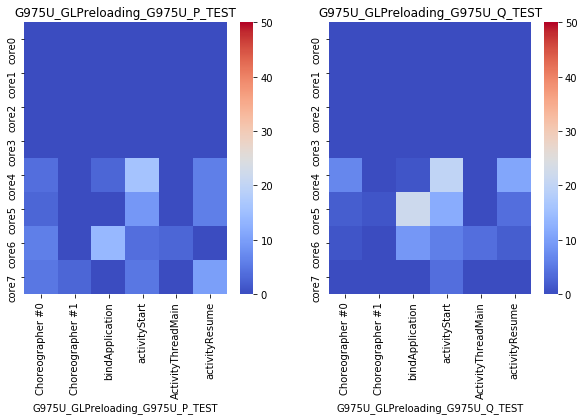

In [53]:
df1 = group1.get(group1.cores(), func='sum')
df1 = df1.dropna(axis=1)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(group2.cores(), func='sum')
df2 = df2.dropna(axis=1)
df2.columns.name = group2.title
#display(df2)
display(pd.concat([df1, df2], keys=[group1.title, group2.title], sort=False))

plt.figure(figsize=(10, 5))
#sb.palplot(sb.color_palette("hls", 8))
subplot(1,2,1, title=group1.title)
sb.heatmap(data=df1, cmap='coolwarm', center=25, vmax = 50);
subplot(1,2,2, title=group2.title)
sb.heatmap(data=df2, cmap='coolwarm', center=25, vmax = 50);

In [54]:
for parser in group1.parsers_of_testing:
    display(parser.get(group1.cores()))

,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,0,0,0,0,NaN
core1,NaN,0,0,0,0,0,0,NaN
core2,NaN,0,0,0,0,0,0,NaN
core3,NaN,0,0,0,0,0,0,NaN
core4,NaN,4,0,3,16,0,6,NaN
core5,NaN,3,0,0,9,0,6,NaN
core6,NaN,6,0,14,4,3,0,NaN
core7,NaN,5,3,0,5,0,10,NaN


In [55]:
for parser in group2.parsers_of_testing:
    display(parser.get(group2.cores()))

,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,0,0,0,0,NaN
core1,NaN,0,0,0,0,0,0,NaN
core2,NaN,0,0,0,0,0,0,NaN
core3,NaN,0,0,0,0,0,0,NaN
core4,NaN,7,0,1,20,0,11,NaN
core5,NaN,2,1,22,12,0,4,NaN
core6,NaN,1,0,9,6,4,2,NaN
core7,NaN,0,0,0,4,0,0,NaN


In [56]:
from systrace_parser import TAG_CORE_IDLE
def GetCoreStats(group):
    for parser in group.parsers_of_testing:
        rawdata = parser.get_rawdata('stat_core')
        index_key_list = list()
        df_list = list()
        
        for index_key in rawdata.keys():
            #print(index_key)
            index_key_list.append(index_key)

            core_state_dict = dict()
            for i in range(8):
                core_state_dict[i] = list()
            core_state_dict['selected'] = list()
            core_state_dict['time'] = list()

            for core_state in rawdata[index_key]:
                for i in range(8):
                    core_state_dict[i].append(core_state.get(i, TAG_CORE_IDLE))
                core_state_dict['selected'].append(core_state.get('selected', -1))
                core_state_dict['time'].append(core_state.get('time', -1))
            #display(DataFrame.from_dict(core_state_dict))
            df_list.append(DataFrame.from_dict(core_state_dict))

    return pd.concat(df_list, keys=index_key_list, sort=False).sort_values(by=['time'])
pd.set_option('display.max_rows', 500)

In [57]:
display(GetCoreStats(group1))

0  1  2  3  4  5  6  7  selected         time
ActivityThreadMain 0   I  I  I  I  I  I  V  I         6  1242.712684
                   1   I  R  I  I  I  I  V  I         6  1242.713616
                   2   R  R  R  I  I  I  V  I         6  1242.717488
bindApplication    0   R  I  I  I  I  I  V  I         6  1242.721430
                   1   R  R  I  I  R  I  V  I         6  1242.721672
                   2   R  I  I  R  I  I  V  I         6  1242.721751
                   3   R  I  I  R  R  I  V  I         6  1242.721783
                   4   I  R  R  R  I  I  V  I         6  1242.722167
                   5   R  I  R  I  I  I  V  I         6  1242.722842
                   6   R  I  I  I  I  I  V  I         6  1242.723029
                   7   I  I  I  R  I  I  V  I         6  1242.723929
                   8   I  R  I  R  I  I  V  I         6  1242.724195
                   9   I  I  I  I  I  I  V  I         6  1242.725544
                   10  I  I  I  I  I  I  V  I         6  1242.725989
                   11  I  I  I  I  I  I  V  I         6  1242.726089
                   12  R  I  R  I  I  I  V  I         6  1242.727342
                   13  I  I  I  I  V  I  I  I         4  1242.732174
                   14  I  I  I  I  V  I  I  I         4  1242.732753
                   15  I  I  I  I  V  I  I  I         4  1242.733198
                   16  I  I  I  I  V  I  I  I         4  1242.733769
activityStart      0   I  I  I  I  I  V  R  R         5  1242.843361
                   1   I  I  I  R  I  V  R  I         5  1242.843885
                   2   I  I  I  R  V  I  R  I         4  1242.844974
                   3   I  R  I  R  V  I  R  I         4  1242.845021
                   4   I  I  I  R  R  I  V  I         6  1242.851592
                   5   R  I  I  R  I  I  V  I         6  1242.852249
                   6   R  I  I  R  V  I  I  I         4  1242.852492
                   7   I  I  I  I  V  I  I  R         4  1242.853201
                   8   R  I  R  I  I  R  I  V         7  1242.854757
                   9   R  I  I  I  V  R  I  I         4  1242.856205
                   10  R  I  I  R  R  R  I  V         7  1242.856596
                   11  I  R  I  I  I  I  I  V         7  1242.858479
                   12  I  I  I  I  V  I  I  I         4  1242.858887
                   13  I  R  I  I  V  I  I  R         4  1242.859158
                   14  I  R  I  I  V  I  I  I         4  1242.859702
                   15  R  R  R  I  R  I  V  R         6  1242.870603
                   16  R  I  I  I  I  I  V  R         6  1242.871211
                   17  R  R  I  I  V  I  I  I         4  1242.871424
                   18  R  I  I  I  I  V  I  I         5  1242.871572
                   19  R  I  I  I  V  I  I  I         4  1242.871757
                   20  R  I  I  I  R  V  I  I         5  1242.871896
                   21  R  R  I  R  I  R  I  V         7  1242.872293
                   22  R  I  R  I  I  V  I  I         5  1242.872468
                   23  I  I  I  R  V  I  I  R         4  1242.872976
                   24  I  I  I  I  I  V  I  I         5  1242.876928
                   25  I  I  I  I  V  I  I  I         4  1242.877135
                   26  I  I  R  I  I  V  I  I         5  1242.878029
                   27  I  I  I  I  V  I  I  I         4  1242.878623
                   28  I  R  R  I  I  I  I  V         7  1242.878986
                   29  I  I  I  I  V  I  I  I         4  1242.879392
                   30  I  I  R  I  V  I  I  I         4  1242.879601
                   31  R  R  R  I  I  V  I  I         5  1242.879982
                   32  I  I  I  I  V  I  I  I         4  1242.880929
                   33  I  I  I  I  I  V  I  I         5  1242.881160
activityResume     0   I  I  I  I  I  V  I  I         5  1242.881541
                   1   I  I  I  I  V  I  I  I         4  1242.882529
                   2   R  I  I  I  I  I  I  V         7  1242.883164
                   3 

In [58]:
display(GetCoreStats(group2))

0  1  2  3  4  5  6  7  selected         time
ActivityThreadMain 0   I  R  I  R  I  I  V  I         6  1596.134429
                   1   I  R  I  R  I  I  V  I         6  1596.134746
                   2   I  I  I  I  R  I  V  I         6  1596.135415
                   3   R  I  I  R  R  V  I  I         5  1596.151749
bindApplication    0   I  I  I  R  I  V  I  I         5  1596.153395
                   1   I  I  I  R  I  V  I  I         5  1596.153612
                   2   R  I  R  I  I  V  I  I         5  1596.154317
                   3   I  I  R  I  I  V  R  R         5  1596.154537
                   4   I  I  I  I  R  V  R  I         5  1596.155412
                   5   I  R  R  R  I  V  I  I         5  1596.155757
                   6   I  I  I  I  I  V  I  I         5  1596.156646
                   7   R  I  I  I  R  V  I  R         5  1596.166605
                   8   I  I  I  R  R  V  R  R         5  1596.167637
                   9   I  I  I  R  R  V  R  R         5  1596.167662
                   10  I  I  I  R  I  V  R  R         5  1596.167687
                   11  I  I  R  R  R  V  R  R         5  1596.167831
                   12  I  I  I  R  R  V  I  R         5  1596.167964
                   13  I  R  I  I  R  V  I  R         5  1596.168541
                   14  I  R  I  I  R  V  I  R         5  1596.169169
                   15  I  R  I  R  R  V  R  R         5  1596.169356
                   16  I  R  I  I  I  V  I  R         5  1596.169380
                   17  I  R  I  I  I  V  R  R         5  1596.169491
                   18  I  R  I  I  I  V  R  R         5  1596.169533
                   19  I  R  I  I  I  V  R  I         5  1596.169578
                   20  I  I  I  I  I  V  R  I         5  1596.169645
                   21  I  I  R  R  I  R  V  I         6  1596.172146
                   22  I  I  I  R  I  R  V  I         6  1596.172289
                   23  I  I  R  I  I  R  V  I         6  1596.172446
                   24  I  I  R  I  I  R  V  I         6  1596.172537
                   25  I  I  I  I  I  R  V  I         6  1596.172590
                   26  I  I  R  I  I  R  V  I         6  1596.173219
                   27  I  I  I  I  I  I  V  I         6  1596.173425
                   28  I  I  I  I  I  I  V  I         6  1596.173619
                   29  I  I  I  I  I  R  V  I         6  1596.173942
                   30  I  I  R  I  V  R  I  I         4  1596.174538
                   31  I  I  R  I  I  I  V  I         6  1596.174663
activityStart      0   I  I  I  I  I  I  V  I         6  1596.175029
                   1   I  I  R  R  I  R  V  I         6  1596.175732
                   2   R  I  I  I  I  I  V  I         6  1596.176179
                   3   I  I  I  I  I  V  I  R         5  1596.176688
                   4   I  I  I  I  I  V  I  R         5  1596.176754
                   5   I  I  I  I  I  V  I  I         5  1596.176837
                   6   I  I  I  R  I  V  I  R         5  1596.177050
                   7   I  R  I  I  V  I  I  I         4  1596.189968
                   8   I  R  I  I  V  I  I  I         4  1596.191214
                   9   I  R  I  I  V  I  I  I         4  1596.191463
                   10  I  R  R  R  V  R  I  I         4  1596.192845
                   11  I  I  R  R  V  R  I  R         4  1596.193649
                   12  I  I  R  I  V  R  I  R         4  1596.193994
                   13  I  I  I  I  V  I  I  I         4  1596.194907
                   14  I  I  I  I  V  I  I  I         4  1596.195499
                   15  I  I  R  R  V  I  I  R         4  1596.196477
                   16  I  I  R  R  V  R  I  R         4  1596.196615
                   17  I  I  R  R  V  I  I  I         4  1596.197849
                   18  I  R  I  I  I  I  V  I         6  1596.199172
                   19  I  R  I  R  I  I  V  I         6  1596.199746
                   20  I  R  I  I  I  I  R  V         7  1596.200822
                   21

### Cpu Frequency

The graph to show a min lock status of core frequency.

In [59]:
from systrace_parser import CPU_FREQUENCY_LIMITS
def DrawCorrectedData(group, tyep_filter, data_label, func):
    prevalue = dict()
    list_of_df_for_start = group.get_marking_time(dtype='start')
    list_of_df_for_end = group.get_marking_time(dtype='end')
    idx = 0

    for item in group.get(tyep_filter, func='array'):
        df = DataFrame(item, columns=['cpu_id', 'time', data_label])
        df = df.apply(pd.to_numeric)
        
        ### to darw launcging time ++
        min_freq = df[data_label].min()
        prevalue['launching'] = min_freq
        
        if len(list_of_df_for_start) > idx:
            launching_time = list_of_df_for_start[idx]['launching'].max()
            if launching_time > 0:
                df = df.append({'cpu_id' : 'launching', 
                           'time' : launching_time, 
                           data_label : ((min_freq + 1) * 2)}, ignore_index=True) 
        if len(list_of_df_for_end) > idx:
            launching_time = list_of_df_for_end[idx]['launching'].max()
            if launching_time > 0:
                df = df.append({'cpu_id' : 'launching', 
                           'time' : launching_time,
                           data_label : min_freq}, ignore_index=True)
        ### to darw launcging time --
        
        if func != 0:
            df = func(df)
            
        length = len(df.index)
            
        for i in range(length):
            #display(df.iloc[i])
            if df.iloc[i]['cpu_id'] in prevalue.keys():
                df = df.append({'cpu_id' : df.iloc[i]['cpu_id'], 
                           'time' : (df.iloc[i]['time'] - 0.000001), 
                           data_label : prevalue[df.iloc[i]['cpu_id']]}, ignore_index=True) 
                #display(df.iloc[i])
            prevalue[df.iloc[i]['cpu_id']] = df.iloc[i][data_label]
        
        idx += 1
        df.index = df['time']
        df = df.sort_index()
        df.groupby(['cpu_id'])[data_label].plot(legend=True, figsize=(15,4))
        plt.show()

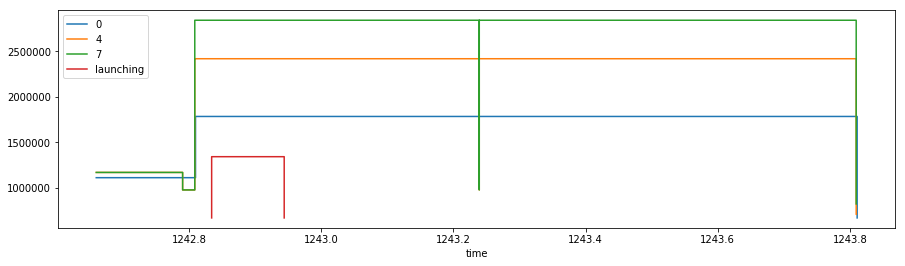

In [60]:
DrawCorrectedData(group1, CPU_FREQUENCY_LIMITS, 'min', 0)

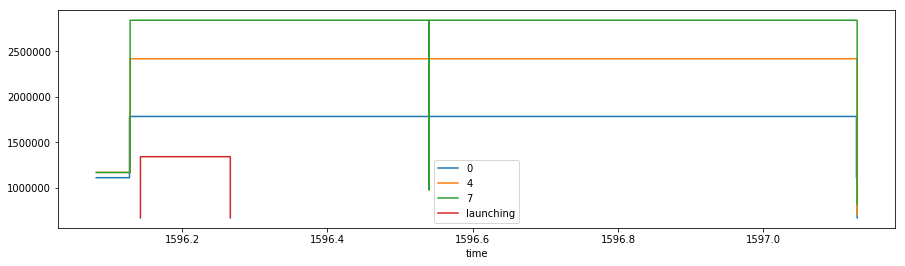

In [61]:
DrawCorrectedData(group2, CPU_FREQUENCY_LIMITS, 'min', 0)

### Cpu Idle

The graph to show a min lock status of core Idle.

In [62]:
from systrace_parser import CPU_IDLE
def PreprocessingForCPUIDLE(df):
    try :
        df_launching = df[df.cpu_id == 'launching']
    except :
        df = pd.concat([df[df.cpu_id == 0], df[df.cpu_id == 4], df[df.cpu_id == 7]])

        df.loc[df.state >= 4294967295, 'state'] = -1
        df['state'] = df['state'] + 1
        
        return df

    df = pd.concat([df[df.cpu_id == 0], df[df.cpu_id == 4], df[df.cpu_id == 7]])

    df.loc[df.state >= 4294967295, 'state'] = -1
    df['state'] = df['state'] + 1
    
    df = df[df.time >= (df_launching['time'].iloc[0] - 0.1)]
    df = df[df.time <= (df_launching['time'].iloc[1] + 0.1)]
    
    df = pd.concat([df, df_launching])
    return df

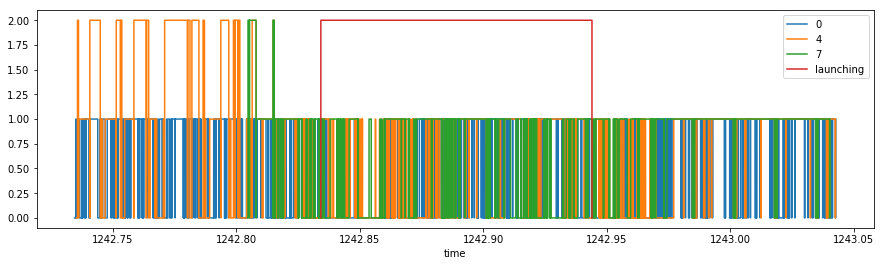

In [63]:
DrawCorrectedData(group1, CPU_IDLE, 'state', PreprocessingForCPUIDLE)

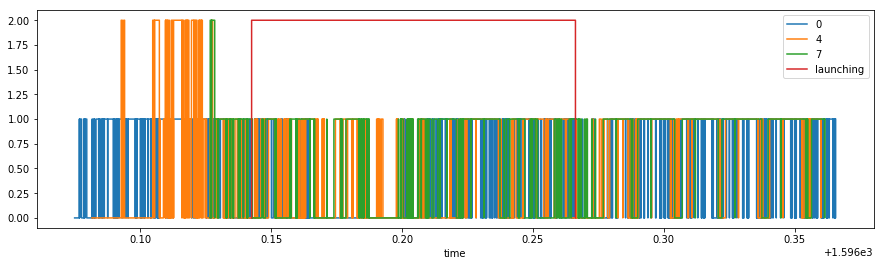

In [64]:
DrawCorrectedData(group2, CPU_IDLE, 'state', PreprocessingForCPUIDLE)

### Lock Contention

In [65]:
df1 = group1.get(['lock_contention']) * 1000
df1 = df1.fillna(0)
df1 = df1.round(3)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(['lock_contention']) * 1000
df2 = df2.fillna(0)
df2 = df2.round(3)
df2.columns.name = group2.title
#display(df2)

df_gap = df1 - df2
df_gap.columns.name = 'DIFF'
#display(df_gap)

display(pd.concat([df1, df2, df_gap], keys=[group1.title, group2.title, 'DIFF'], sort=False))
#display(pd.concat([df1[:1], df2[:1], df_gap[:1]], keys=[group1.title, group2.title, 'DIFF'], sort=False))

,,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
G975U_GLPreloading_G975U_P_TEST,lock_contention,0,5.718,4.513,0.000,17.459,0.000,0,0
G975U_GLPreloading_G975U_Q_TEST,lock_contention,0,4.515,0.000,0.453,17.626,16.297,0,0
DIFF,lock_contention,0,1.203,4.513,-0.453,-0.167,-16.297,0,0


In [66]:
def DrawLockContention(parser):
    for lock_contention in parser.storage_lock_contention:
        lock_contention['owner'] = lock_contention['context'].split('owner ')[1].split(' waiters')[0]
        lock_contention['blocking'] = lock_contention['context'].split('blocking from')[1]
    df = DataFrame.from_dict(parser.storage_lock_contention)
    df.loc[df['duration'] > 0, 'duration'] *= 1000

    return df
        #if value == 'NaN':
            
        #else:
        #    display(DataFrame(df[value].value_counts()))

Liminated the lock contentions by the main thread is sleepping in an app.
(The effection means that lock contentions seem to effect to the app entry because the process stat was sleep.)

In [67]:
#for parser in group.parsers_of_testing:
parser = group1.parsers_of_testing[0]
df = DrawLockContention(parser)
df1 = df[df['effection'] == 'O']
display(group1.title)
display(df1.sort_values(by=['duration'], ascending=False))

u'G975U_GLPreloading_G975U_P_TEST'

,blocking,context,duration,effection,owner,pid,time,type
42,java.util.List com.android.server.am.Activity...,monitor contention with owner Binder:1194_19 (...,10.272,O,Binder:1194_19 (8538) at void com.android.serv...,3120,1242.859919,B
117,void com.android.server.wm.WindowManagerServi...,monitor contention with owner Binder:1194_12 (...,5.408,O,Binder:1194_12 (3542) at int com.android.serve...,1358,1243.254638,B
25,void com.android.server.wm.WindowManagerServi...,monitor contention with owner android.anim (16...,5.008,O,android.anim (1604) at int com.android.server....,3542,1242.835718,B
32,int com.android.server.am.ActivityManagerServ...,monitor contention with owner Binder:1194_12 (...,4.648,O,Binder:1194_12 (3542) at void com.android.serv...,8538,1242.845203,B
54,void com.android.server.wm.WindowManagerServi...,monitor contention with owner Binder:1194_9 (2...,3.439,O,Binder:1194_9 (2124) at int com.android.server...,1358,1242.904929,B
26,void com.android.server.wm.WindowManagerServi...,monitor contention with owner android.anim (16...,3.368,O,android.anim (1604) at int com.android.server....,1358,1242.837430,B
44,void com.android.server.wm.WindowManagerServi...,monitor contention with owner android.anim (16...,2.703,O,android.anim (1604) at void com.android.server...,3542,1242.867249,B
115,void com.android.server.wm.WindowSurfacePlace...,monitor contention with owner Binder:1194_12 (...,2.583,O,Binder:1194_12 (3542) at int com.android.serve...,1604,1243.253070,B
116,int com.android.server.wm.WindowManagerServic...,monitor contention with owner Binder:1194_12 (...,2.468,O,Binder:1194_12 (3542) at int com.android.serve...,8538,1243.253929,B
33,int com.android.server.am.MultiWindowManagerS...,monitor contention with owner Binder:1194_12 (...,1.900,O,Binder:1194_12 (3542) at void com.android.serv...,2124,1242.847833,B


In [68]:
#for parser in group.parsers_of_testing:
parser = group2.parsers_of_testing[0]
df = DrawLockContention(parser)
df2 = df[df['effection'] == 'O']
display(group2.title)
display(df2.sort_values(by=['duration'], ascending=False))

u'G975U_GLPreloading_G975U_Q_TEST'

,blocking,context,duration,effection,owner,pid,time,type
28,int com.android.server.am.ActivityManagerServ...,monitor contention with owner Binder:992_3 (50...,8.100,O,Binder:992_3 (5057) at void com.android.server...,5452,1596.143617,B
34,void com.android.server.am.ActivityManagerSer...,monitor contention with owner Binder:992_3 (50...,7.290,O,Binder:992_3 (5057) at void com.android.server...,1143,1596.144609,B
19,void com.android.server.wm.WindowAnimator.lam...,monitor contention with owner Binder:992_A (54...,5.164,O,Binder:992_A (5452) at int com.android.server....,1147,1596.137568,B
20,void com.android.server.wm.TaskChangeNotifica...,monitor contention with owner Binder:992_A (54...,4.704,O,Binder:992_A (5452) at int com.android.server....,1143,1596.138094,B
46,boolean com.android.server.wm.WindowProcessCo...,monitor contention with owner android.anim (11...,3.882,O,android.anim (1147) at int com.android.server....,5452,1596.155550,B
51,void com.android.server.wm.WindowManagerServi...,monitor contention with owner Binder:992_3 (50...,3.349,O,Binder:992_3 (5057) at void com.android.server...,1147,1596.166558,B
152,void com.android.server.wm.WindowManagerServi...,monitor contention with owner Binder:992_12 (7...,3.308,O,Binder:992_12 (7471) at int com.android.server...,1143,1596.557373,B
118,void com.android.server.wm.WindowManagerServi...,monitor contention with owner Binder:992_A (54...,3.302,O,Binder:992_A (5452) at int com.android.server....,1143,1596.241167,B
47,void com.android.server.wm.WindowManagerServi...,monitor contention with owner android.anim (11...,3.158,O,android.anim (1147) at int com.android.server....,1143,1596.156337,B
52,android.app.ActivityManager$StackInfo com.and...,monitor contention with owner Binder:992_3 (50...,3.137,O,Binder:992_3 (5057) at void com.android.server...,1143,1596.166887,B


Sum of the lock contention's duration. The durations could be duplicated.

In [69]:
display(group1.title)
display(df1['duration'].sum())

u'G975U_GLPreloading_G975U_P_TEST'

51.4119999995728

In [70]:
display(group2.title)
display(df2['duration'].sum())

u'G975U_GLPreloading_G975U_Q_TEST'

87.24799999959032

Liminated the lock contentions by owners.

In [71]:
parser = group1.parsers_of_testing[0]
df = DrawLockContention(parser)
df = df[df['effection'] == 'O']
display(group1.title)
display(DataFrame(df['owner'].value_counts()))

u'G975U_GLPreloading_G975U_P_TEST'

,owner
android.anim (1604) at void com.android.server.wm.WindowAnimator.animate(long)(WindowAnimator.java:153),4
"Binder:1194_12 (3542) at int com.android.server.wm.WindowManagerService.relayoutWindow(com.android.server.wm.Session, android.view.IWindow, int, android.view.WindowManager$LayoutParams, int, int, int, int, long, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.view.DisplayCutout$ParcelableWrapper, android.util.MergedConfiguration, android.view.Surface, android.graphics.PointF, com.samsung.android.view.ConventionalModeBar$Info)(WindowManagerService.java:2217)",3
"Binder:1194_19 (8538) at void com.android.server.am.ActivityManagerService.setTaskDescription(android.os.IBinder, android.app.ActivityManager$TaskDescription)(ActivityManagerService.java:13842)",2
"Binder:1194_9 (2124) at java.util.List com.android.server.am.ActivityManagerService.getFilteredTasks(int, int, int)(ActivityManagerService.java:13683)",2
"android.anim (1604) at int com.android.server.wm.WindowManagerService.relayoutWindow(com.android.server.wm.Session, android.view.IWindow, int, android.view.WindowManager$LayoutParams, int, int, int, int, long, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.view.DisplayCutout$ParcelableWrapper, android.util.MergedConfiguration, android.view.Surface, android.graphics.PointF, com.samsung.android.view.ConventionalModeBar$Info)(WindowManagerService.java:2217)",2
Binder:1194_19 (8538) at android.app.ActivityManager$StackInfo com.android.server.am.ActivityManagerService.getFocusedStackInfo()(ActivityManagerService.java:26903),2
Binder:1194_12 (3542) at void com.android.server.am.ActivityManagerService.activityPaused(android.os.IBinder)(ActivityManagerService.java:10410),2
"Binder:1194_9 (2124) at boolean android.os.MessageQueue.enqueueMessage(android.os.Message, long)(MessageQueue.java:544)",1
"Binder:1194_F (3120) at void com.android.server.InputMethodManagerService.onSessionCreated(com.android.internal.view.IInputMethod, com.android.internal.view.IInputMethodSession, android.view.InputChannel)(InputMethodManagerService.java:3119)",1
"ActivityManager (1308) at void com.android.server.am.TaskChangeNotificationController.forAllRemoteListeners(com.android.server.am.TaskChangeNotificationController$TaskStackConsumer, android.os.Message)(TaskChangeNotificationController.java:246)",1


In [72]:
parser = group2.parsers_of_testing[0]
df = DrawLockContention(parser)
df = df[df['effection'] == 'O']
display(group2.title)
display(DataFrame(df['owner'].value_counts()))

u'G975U_GLPreloading_G975U_Q_TEST'

,owner
android.anim (1147) at void com.android.server.wm.WindowAnimator.animate(long)(WindowAnimator.java:141),8
android.display (1143) at int com.android.server.wm.MultiTaskingManager.getMultiWindowModeStates(int)(MultiTaskingManager.java:568),4
"android.ui (1130) at java.util.List com.android.server.wm.ActivityTaskManagerService.getFilteredTasks(int, int, int)(ActivityTaskManagerService.java:3231)",4
android.anim (1147) at void com.android.server.wm.WindowAnimator.animate(long)(WindowAnimator.java:132),4
android.anim (1147) at void com.android.server.wm.WindowSurfacePlacer.lambda$new$0$WindowSurfacePlacer()(WindowSurfacePlacer.java:65),3
"Binder:992_12 (7471) at int com.android.server.wm.WindowManagerService.relayoutWindow(com.android.server.wm.Session, android.view.IWindow, int, android.view.WindowManager$LayoutParams, int, int, int, int, long, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.view.DisplayCutout$ParcelableWrapper, android.util.MergedConfiguration, android.view.SurfaceControl, android.view.InsetsState)(WindowManagerService.java:2194)",3
"Binder:992_3 (5057) at void com.android.server.am.ActivityManagerService.attachApplication(android.app.IApplicationThread, long)(ActivityManagerService.java:5941)",3
android.display (1143) at void com.android.server.wm.WindowManagerService$H.handleMessage(android.os.Message)(WindowManagerService.java:5248),2
"android.display (1143) at java.util.List com.android.server.pm.PackageManagerService.queryIntentActivitiesInternal(android.content.Intent, java.lang.String, int, int, int, boolean, boolean)(PackageManagerService.java:8542)",2
"android.display (1143) at void com.android.server.wm.ActivityMetricsLogger.checkVisibility(com.android.server.wm.TaskRecord, com.android.server.wm.ActivityRecord)(ActivityMetricsLogger.java:575)",2


Text(0,0.5,'weight')

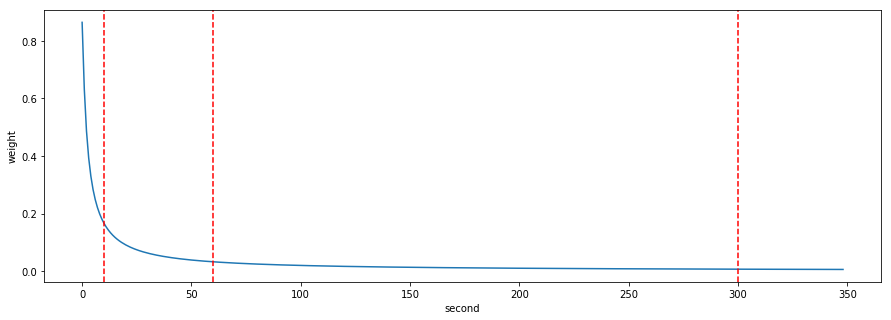

In [73]:
from math import exp


#display(np.exp(-2.0/np.arange(1,300.0)) * 2048)
plt.figure(figsize=(15,5))
plt.plot(1 - np.exp(-2.0/np.arange(1,350.0)))
plt.axvline(x=10, color='r', linestyle='--')
plt.axvline(x=60, color='r', linestyle='--')
plt.axvline(x=300, color='r', linestyle='--')
plt.xlabel('second')
plt.ylabel('weight')